In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pygsp as pg
from pygsp import plotting
from scipy.linalg import expm
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

We will try to do a simple example, let's take a delta for each node and evolve it with time

In [3]:
N = 5 # number of nodes for our graph
G = pg.graphs.Path(N) # create path graph with N nodes

Deltas are the columns here

In [4]:
H = np.eye(N)

Take third column and plot it

Text(0.5, 1.0, 'Signal at time t=0')

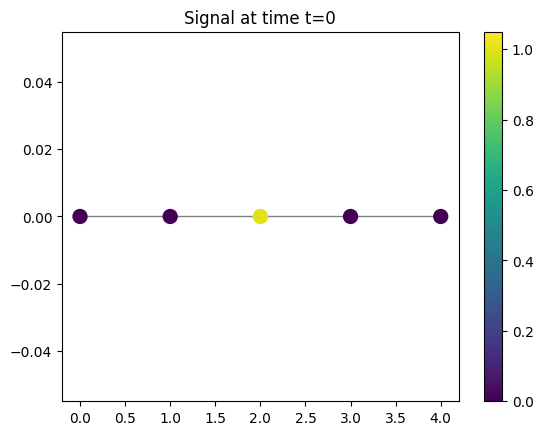

In [5]:
plotting.plot_signal(G,H[:,2])
plt.title("Signal at time t=0")

Let's evolve each signal $\tau=[1,2.5,4]$ units of time

Text(0.5, 1.0, 'Signal at rate 2.5, delta at the end')

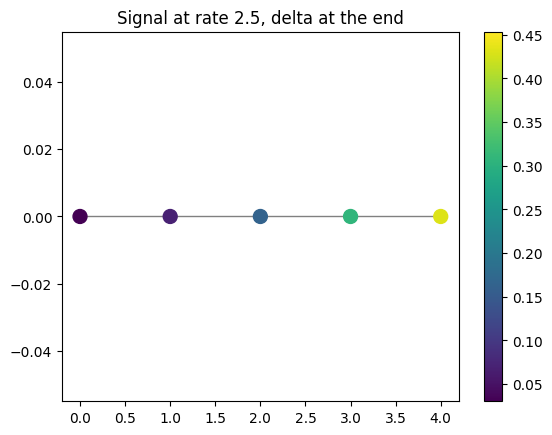

In [6]:
# extract the Laplacian from the line graph
L = G.L.toarray()
L = L/np.trace(L)*(L.shape[0])
# evolve the eye signal
signals = []
taus = [1,2.5,4]
for tau in taus:
    signals.append(expm(-tau*L)@H)
plotting.plot_signal(G,signals[1][:,4])
plt.title("Signal at rate 2.5, delta at the end")

Trying to learn from the diffused signal

In [7]:
import learnHeat as lh
# concatenate created signals
X = np.concatenate([signal for signal in signals], axis=1)
# create random graph and Laplacian
M = X.shape[1]

_, L0, H0, tau0 = lh.create_signal(N=N,tau_ground=[1,2,3],M=M,se=0.1)

In [8]:
L0

array([[ 0,  0,  0,  0,  0],
       [ 0,  3, -1, -1, -1],
       [ 0, -1,  1,  0,  0],
       [ 0, -1,  0,  1,  0],
       [ 0, -1,  0,  0,  1]])

In [9]:
X.shape[:],L.shape[:],H.shape[:],len(taus) # H shape is wrong

((5, 15), (5, 5), (5, 5), 3)

In [10]:
result = lh.learn_heat(X = X, 
                    L0=L, H0 = np.random.rand(15,15), tau0=[1,2,3], 
                    verbose=False, 
                    max_iter = 50, alpha = 0.1, beta=0.0)

Learning progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [11]:
result["L"]

array([[ 0.64371, -0.64372,  0.     ,  0.     ,  0.     ],
       [-0.64372,  0.87015, -0.22644, -0.     ,  0.     ],
       [ 0.     , -0.22644,  0.94637, -0.71994,  0.     ],
       [ 0.     , -0.     , -0.71994,  1.62986, -0.90992],
       [ 0.     ,  0.     ,  0.     , -0.90992,  0.90991]])

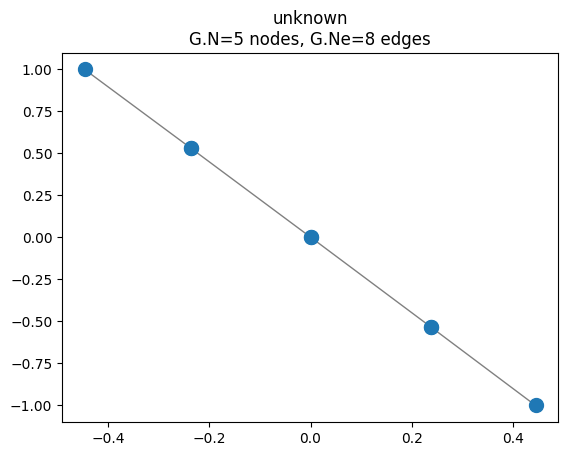

In [12]:
Lres = result["L"]
Lres[abs(Lres)<0.01] = 0
Adj = -np.copy(result["L"])
np.fill_diagonal(Adj, 0)
G_learned = pg.graphs.Graph(Adj)
G_learned.set_coordinates()
plotting.plot_graph(G_learned)

Now for the same graph, can we do the same technique with noise?

In [13]:
se = 0.1 # standard deviation
noisyX = X + se*np.random.randn(X.shape[0],X.shape[1])
noisy_result = lh.learn_heat(X = X, 
                    L0=L, H0 = np.random.rand(15,15), tau0=[1,2,3], 
                    verbose=False, 
                    max_iter = 50, alpha = 0.1, beta=0.01)

Learning progress:   0%|          | 0/50 [00:00<?, ?it/s]

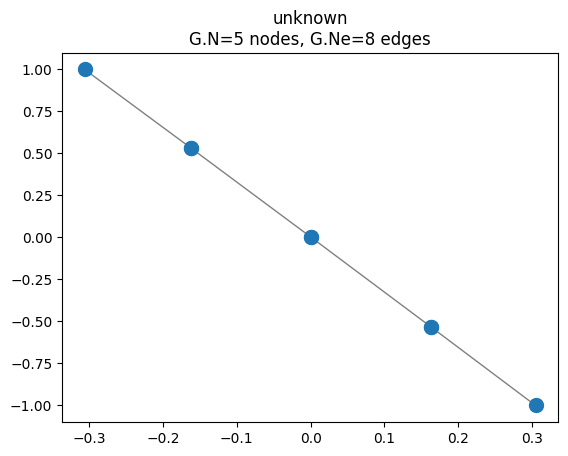

In [14]:
# do the same
noisy_Lres = result["L"]
noisy_Lres[abs(Lres)<0.01] = 0
noisy_Adj = -np.copy(result["L"])
np.fill_diagonal(noisy_Adj, 0)
noisy_G_learned = pg.graphs.Graph(noisy_Adj)
noisy_G_learned.set_coordinates()
plotting.plot_graph(noisy_G_learned)

Can we do the same with an arbitrary graph?

Let's create a random bigger graph with $N=20$ as in the paper.

In [15]:
from importlib import reload
lh = reload(lh)
big_N = 20
big_graph = nx.gnp_random_graph(big_N,p=0.4)
big_L = nx.laplacian_matrix(big_graph).toarray()
# we should normalize
big_L = big_L/np.trace(big_L)*big_N
big_tau = [0.5,1,1.5,2,3]
big_X = lh.create_deltas(big_L,big_tau,se=0)

Let's create false L, H, $\tau$ to feed the algorithm together with the noisy signal

In [16]:
big_M = big_X.shape[1]
_, not_L, not_H, not_tau = lh.create_signal(N=big_N,M=big_M,tau_ground=big_tau)

In [17]:
big_res = lh.learn_heat(X=big_X,L0=not_L,H0=not_H,tau0=not_tau,alpha=0.05,beta=0.05,max_iter=50)

Learning progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [18]:
big_L_learned = big_res["L"]
# create adjacency
big_W = -big_L_learned
np.fill_diagonal(big_W,0)
# cap with some threshold
big_W[abs(big_W)<0.01]=0

In [19]:
big_tp = np.sum((big_W>0)&(big_L<0))
big_fp = np.sum((big_W>0)&(big_L>=0))
big_fn = np.sum((big_W<=0)&(big_L<0))

In [20]:
precision = big_tp/(big_tp+big_fp)

In [21]:
recall = big_tp/(big_tp+big_fn)

In [22]:
f_measure = 2/(1/precision + 1/recall)
f_measure
# we obtain 0.75 it is ok

0.7605633802816901

Finally, we will try to learn a ring!!!

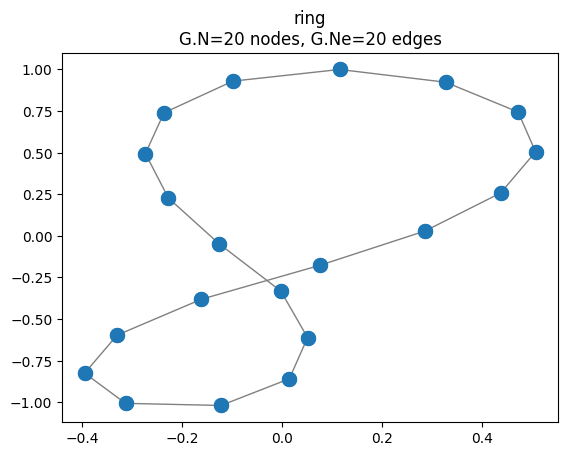

In [23]:
Nring = 20
Gring = pg.graphs.Ring(Nring,1)
Gring.set_coordinates()
plotting.plot_graph(Gring)

In [30]:
Lring = Gring.L.todense()
Lring = Lring/np.trace(Lring)*Lring.shape[0]
tauring = [0.5,1,1.5,5]
Xring = lh.create_deltas(Lring,tauring)

_, notLring, Hring, tauring = lh.create_signal(N=Lring.shape[0],M=Xring.shape[1],tau_ground=tauring)

In [51]:
resring = lh.learn_heat(X=Xring,L0=notLring,H0=Hring,tau0=[1,1,1,2],alpha=0.05,beta=0.05,max_iter=50)

Learning progress:   0%|          | 0/50 [00:00<?, ?it/s]

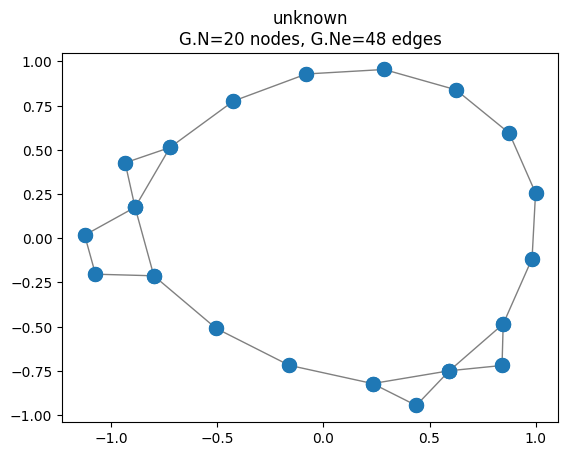

In [67]:
learned_ring = -resring["L"]
np.fill_diagonal(learned_ring,0)
# do a film on threshold
learned_ring[learned_ring < 0.17] = 0
Glearnedring = pg.graphs.Graph(learned_ring)
Glearnedring.set_coordinates()
plotting.plot_graph(Glearnedring)

Final simple examples
### Trying to learn an Erdos Renyi graph

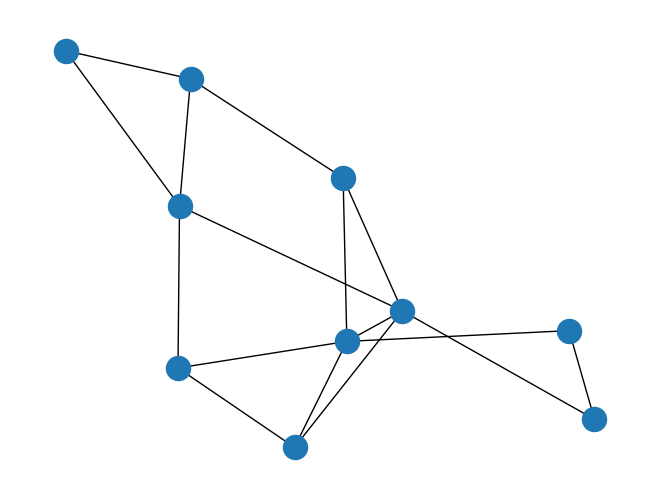

In [72]:
G = nx.erdos_renyi_graph(10,0.4)
tau_ground = [0.5,1,2.5,4]
nx.draw(G)
L = nx.laplacian_matrix(G).toarray()

In [73]:
X = lh.create_deltas(L,tau_ground)

In [75]:
res = lh.learn_heat(X=X,tau0=[1,2,3,4],alpha=0.05,beta=0.02,max_iter=75)

Learning progress:   0%|          | 0/75 [00:00<?, ?it/s]

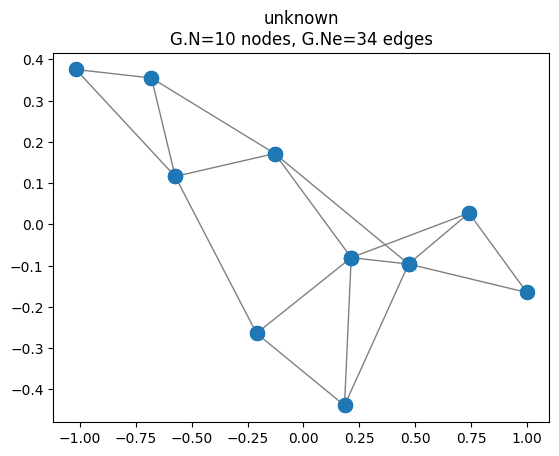

In [79]:
W = -res["L"]
np.fill_diagonal(W,0)
W[W<0.1] = 0
G_learned=pg.graphs.Graph(W)
G_learned.set_coordinates()
plotting.plot_graph(G_learned)

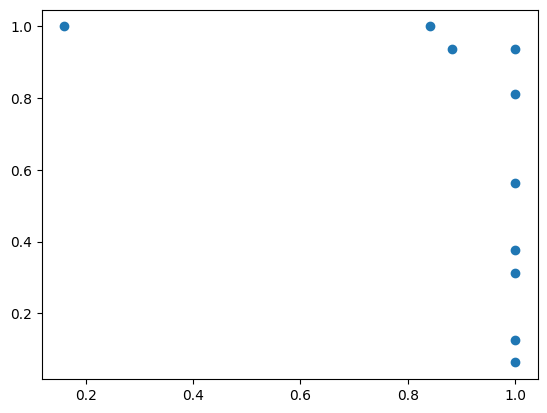

In [81]:
precision, recall = lh.heat_scores(res["L"],L)
plt.scatter(precision,recall)

Doing the same with an RBF graph

In [83]:
_, L, _, _ = lh.create_signal2(N=10,se=0)

In [84]:
X = lh.create_deltas(L,tau_ground)

Learning progress:   0%|          | 0/75 [00:00<?, ?it/s]

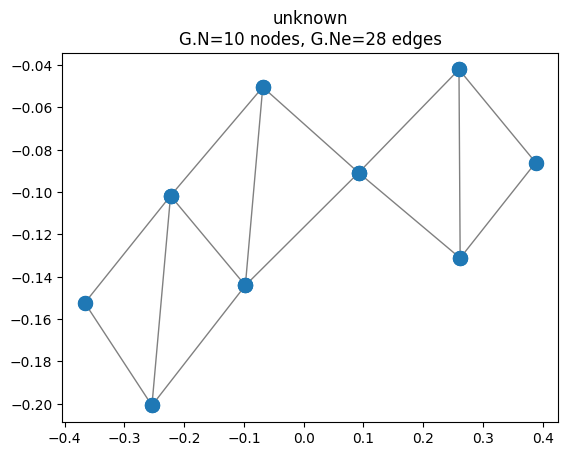

In [86]:
res = lh.learn_heat(X=X,tau0=[1,2,3,4],alpha=0.05,beta=0.02,max_iter=75)
W = -res["L"]
np.fill_diagonal(W,0)
W[W<0.1] = 0
G_learned=pg.graphs.Graph(W)
G_learned.set_coordinates()
plotting.plot_graph(G_learned)

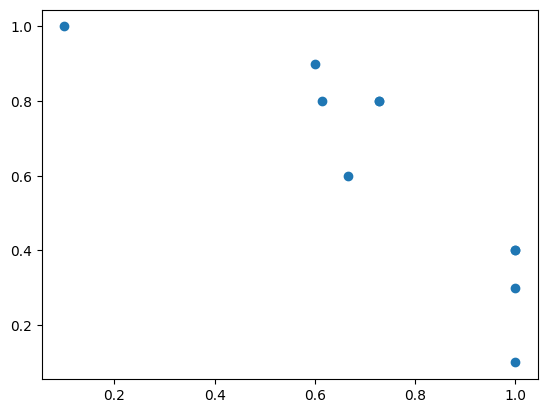

In [88]:
precision, recall = lh.heat_scores(res["L"],L)
plt.scatter(precision,recall)